# Volatility Models - Project
Cojutti Francesco - Khalil Hassan - Ngoc Truong Nguyen

#  2) Implied volatility in the Lifted Heston model

In [ ]:
# Import the necessary package
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
!pip install py_vollib
import py_vollib.black_scholes.implied_volatility as bs_iv

##Exercise 2.3 and 2.4

###2.3)  Approximate the characteristic function
We following the general step below:
- Step 1: Calculate the vector of n factors of c and x using:
\begin{align}
c_i &= \frac{(r_{n}^{1-\alpha} - 1)}{\Gamma(\alpha)\Gamma(2 - \alpha)} r_{n}^{(1-\alpha)(i - \frac{1}{2}n)} \\
x_i &= \frac{(1 - \alpha) r_{n}^{2-\alpha} - 1}{(2 - \alpha) r_{n}^{1-\alpha} - 1} r_{n}^{i-1-\frac{1}{2}n}
\end{align}

- Step 2: Calulate $g_{0}(t_k)$ at each time grid using formula from Q1:
\begin{equation}
    g_{0}(t_k) = V_0 + \lambda \theta \sum_{i=1}^{n} c_i e^{-x_i t_k}
\end{equation}
-Step 3: Using implicit scheme to update the $\psi$ function:
\begin{equation}
\psi_0^i = 0, \quad \psi_{t_{k+1}}^i = \frac{1}{1+x_i\Delta t}\left(\psi_{t_{k}}^{i} + \Delta t F\left(ui, \sum_{j=1}^n c_j\psi_{t_k}^j \right)\right)
\end{equation}

- Step 4: Approximate charateristic function using simple Riemann scheme at each time grid:
\begin{equation}
   \Phi_T(u) \approx \exp\left( ui\log(S_0) + \sum_{k=0}^{N-1} F\left( ui, \sum_{j=1}^n c_j\psi^j (t_k)\right) g_0(T - t_k)\Delta t \right)
\end{equation}



###2.4) Approximate the call option price
- Using a numerical integration formula in python (quad) to approximate the Carr-Madan formula

In [ ]:
# Here we create a class Lifted Heston, to make this more organized to track all the function
class Lifted_Heston:
    def __init__(self, M, T, n,rn,alpha, v0, lam, theta, nu, rho):
        self.M = M # number of discretization steps
        self.T = T # maturity time
        self.n = n # number of factors
        self.rn = rn # constant used to parametrize x and c
        self.alpha = alpha # constant used to parametrize x and c
        self.v0 = v0 # Intial Volatility
        self.lam = lam # lambda
        self.theta = theta # theta
        self.nu = nu #vega
        self.rho = rho # correlation paramter
        self.delta = T / M # time grid
        self.time_grid = np.array([i * self.delta for i in range(M + 1)]) # cumulative time grid

        # We calculate vector of weights and mean reversion using formula in page 10 (Part III)
        self.c = np.array([(self.rn**(1-self.alpha)-1)*(self.rn**((1-self.alpha)*(i-1-self.n/2)))/(math.gamma(self.alpha)*math.gamma(1-self.alpha)) for i in range(1,self.n+1)])
        self.x = np.array([(1-self.alpha)*(self.rn**(2-self.alpha)-1)*(rn**(i-1-self.n/2))/((2-self.alpha)*(self.rn**(1-self.alpha)-1)) for i in range(1,self.n+1)])

    def g0(self, t):
        # Calculate initial foward variance using formula in Q1
        integral = (1-np.exp(-self.x*t))/self.x
        result = self.v0 + self.lam * self.theta * np.dot(self.c, integral)
        return result


    def compute_g0(self):
       # Update initial curve g0(t) at each time step using formula in Q1 and store it in vector of length M+1
        g0_vec = np.zeros(self.M + 1)
        for k in range(1, self.M + 1):
                g0_vec[k] = self.g0(self.time_grid[k])
        return g0_vec

    def compute_F(self, u, v):
      # The Ricatti ODE equation
        h = 0.5 * ((1j*u)**2 - 1j*u) + (self.rho * self.nu * 1j*u - self.lam) * v + 0.5 * (self.nu**2) * v**2
        return h

    def compute_F_psi(self, u):
      # Using implicit Euler scheme to update psi in page 19 (Part III)
        F_psi_vec = np.zeros(self.M + 1,dtype=complex) # Create a vector store the F value at each time step
      # Then store it in a vector of length M+1
        psi = np.zeros(self.n,dtype=complex)
        for k in range(1, self.M + 1):
            F_value = self.compute_F(u,np.dot(psi, self.c))
            F_psi_vec[k] = F_value
            psi = (1 / (1 + self.x * self.delta)) * (psi + F_value * self.delta)
        return F_psi_vec

    def Ch_Lifted_Heston(self,u,S0):
      # Calculate the CF function in Page 14 (Part III) using simple Riemman scheme
        g0_vec = self.compute_g0()
        F_psi_vec = self.compute_F_psi(u)

        integral_approximation = 0+0j
        for k in range(1, self.M + 1):
            integral_approximation += F_psi_vec[k-1] * g0_vec[M-k+1] * self.delta

        cf = np.exp(1j*u * np.log(S0)+integral_approximation)
        return cf
    def Call_Price_Lifted_Heston(self, S0, K, L, alpha_2):
      # K : strike price for the call option
      # L: truncate level to define the intergral
      # alpha_2: the damping factor
        # Function to calculate the integrand of the Carr-Madan formula
       def integrand(u):
        # Calculate characteristic function for a complex argument
        numerator = self.Ch_Lifted_Heston(u - (alpha_2 + 1) * 1j, S0) * np.exp(-1j * u * np.log(K))
        denominator = (alpha_2 + 1j * u) * (alpha_2 + 1 + 1j * u)

        # We take the real part of the integrand because the integral is taken over the real axis
        return np.real(numerator / denominator)

    # Numerically integrate the Carr-Madan integrand
       integral, _ = quad(integrand, 0, L, limit=1000)

    # Calculate the call price using the Carr-Madan formula
       call_price = (np.exp(0 * self.T - alpha_2 * np.log(K)) / np.pi) * integral
       return call_price

    def plot_iv_vs_log_strike(self, S0, L, alpha_2,l_K,title,r=0):
    # Function use to draw the graph between the implied volatility with log strike price
    # for different factor n
        K = [np.exp(h) for h in l_K]
        implied_vol = []

        for strike in K:
            c_price = self.Call_Price_Lifted_Heston(S0, strike, L, alpha_2)
            # Here we derived implied volatility using built-in pyvolib package
            vol = bs_iv.implied_volatility(c_price, S0, strike ,self.T, r, flag='c')
            implied_vol.append(vol)


        plt.plot(l_K, implied_vol, label=f'n={self.n}')
        plt.xlabel('Log Strike')
        plt.ylabel('Implied Volatility')
        plt.title(title)
        plt.legend()

## 2.5) Plot the implied volatility smiles for $n=5,10,20,50$
### a) $T=1, L=100$ with 20 equidistant log strikes between -1.2 and 0.2

In [ ]:
# The given paramters use to draw a graph in Q
S0=1
K=0.5
rho = -0.7
L=100
lam,theta,nu = 0.3,0.02,0.3
v0 =0.02
alpha = 0.6
alpha_2 = 1
M=100
T=1
l_K = np.linspace(-1.2, 0.2, 20)
title = 'Implied Volatility vs Log Strike (1 year)'

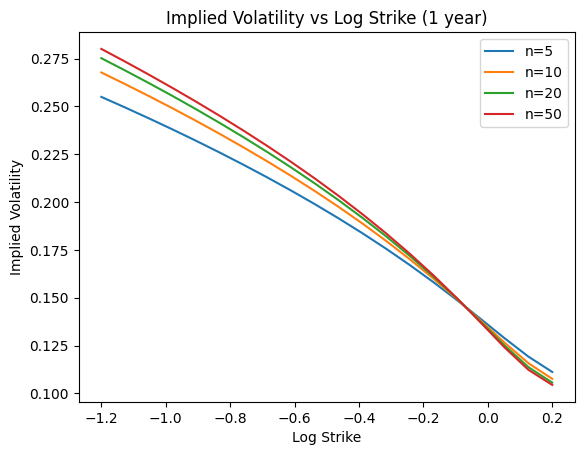

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Plotting for different values of n
n_values = [5, 10, 20, 50]
for n in n_values:
    rn_scaled =  1 + 10 * pow(n, -0.9)
    simulator = Lifted_Heston(M, T, n, rn_scaled, alpha, v0, lam, theta, nu, rho)
    simulator.plot_iv_vs_log_strike(S0, L, alpha_2,l_K,title)
plt.figure(figsize=(12, 8))
plt.show()  # Display the plot

###b) T=1/26, L=1000 with 20 equidistant log strikes between -0.15 and 0.05

In [ ]:
T=1/26
L=1000
l_K = np.linspace(-0.15, 0.05, 20)
title = 'Implied Volatility vs Log Strike (2 weeks)'

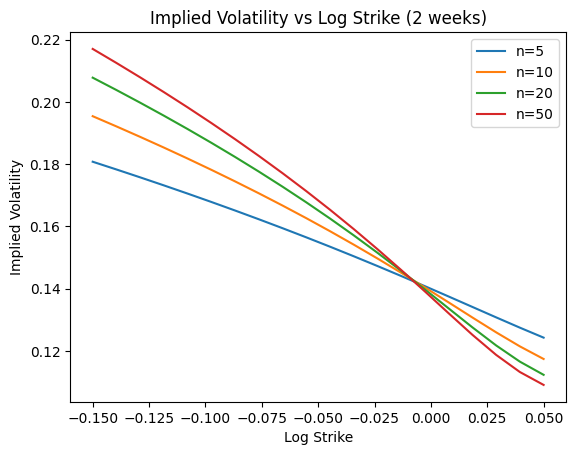

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Plotting for different values of n
n_values = [5, 10, 20, 50]
for n in n_values:
    rn_scaled = 1 + 10 * pow(n, -0.9)
    simulator = Lifted_Heston(M, T, n, rn_scaled, alpha, v0, lam, theta, nu, rho)
    simulator.plot_iv_vs_log_strike(S0, L, alpha_2,l_K,title)
plt.figure(figsize=(12, 8))
plt.show()  # Display the plot
